In [1]:
import pandas as pd
import numpy as np
import warnings

from scipy import stats
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.special import gamma

from joblib import Parallel, delayed

import datetime
from glob import glob

<AxesSubplot:xlabel='time'>

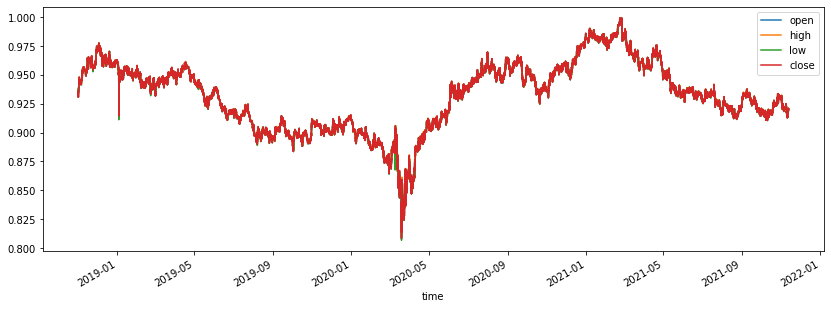

In [2]:
data_path = glob('zip_data/*.csv')[0]
data = pd.read_csv(data_path, index_col=0)
data.index = pd.to_datetime(data.index)
data.plot(figsize=(14,5))

In [13]:

def selection_logic(index_data: datetime.date):
    """
    Определяется поведение разбиения данных на период Lookback и Hold
    :param index_data: Подразумевается что сюда приходит день в который планируется работа стратегии
    :return:
    """
    ASIAN_START = datetime.datetime.combine(index_data, datetime.time(hour=22)) #   Начало азиатской сессии
    ASIAN_END = datetime.datetime.combine(index_data + datetime.timedelta(days=1), datetime.time(hour=8))   #   Конец азиатской сессии == Начало английской
    ENGLISH_END = datetime.datetime.combine(index_data + datetime.timedelta(days=1), datetime.time(hour=22))    #   Конец английской сессии
    return ASIAN_END, ASIAN_START, ENGLISH_END


def FX_opening_trade(sampling_data, UpperBorder, LowerBorder, POSITION_MONEY_VOLUME=10):
    """
    Функция проверяет есть ли точки входа на POTENTIAL_HOLD_DATA периоде
    :param sampling_data:
    :param UpperBorder:
    :param LowerBorder:
    :return:

    >>>sampl = pd.Series([.1,0,1,2,4,1,0])
    >>>FX_opening_trade(sampl, 6, .05) # {'logic': None, 'type': None, 'position': None, 'open_time': None}

    >>>sampl = pd.Series([1,2,3,4,5,6,7])
    >>>FX_opening_trade(sampl, 6, .05) # {'logic': True, 'type': 'BUY', 'position': 14285.714285714286, 'open_time': 6}
    """

    #POSITION_MONEY_VOLUME = 10 #   Параметр отвечающий за размер каждой сделки

    answer_template = {'logic': None, 'type': None, 'position': None, 'open_time': None, 'open_price': None}    #   Унифицированный объем шаблона
    for index in sampling_data.index:
        #   Opening Long Order Logic
        if sampling_data.loc[index] > UpperBorder:
            answer_template['logic'] = True
            answer_template['type'] = "BUY"
            answer_template['position'] = abs(POSITION_MONEY_VOLUME / sampling_data.loc[index])
            answer_template['open_time'] = index
            answer_template['open_price'] = sampling_data.loc[index]
            if sampling_data.loc[index] == 0:
                warnings.warn("Zero Division in case zero price in sample. Sample ignored")
                answer_template = {'logic': None, 'type': None, 'position': None, 'open_time': None, 'open_price': None}
            break

        #   Opening Short Order Logic
        if sampling_data.loc[index] < LowerBorder:
            answer_template['logic'] = True
            answer_template['type'] = "SELL"
            answer_template['position'] = abs(POSITION_MONEY_VOLUME / sampling_data.loc[index])
            answer_template['open_time'] = index
            answer_template['open_price'] = sampling_data.loc[index]
            if sampling_data.loc[index] == 0:
                warnings.warn("Zero Division in case zero price in sample. Sample ignored")
                answer_template = {'logic': None, 'type': None, 'position': None, 'open_time': None, 'open_price': None}
            break
    return answer_template

def FX_hold_logic(holding_data, open_list, SLIPADGE, PROFITS_LIST):
    HoldList = {"hold_logic": "END_PERIOD", "close_time": holding_data.index[-1], "close_price": holding_data.loc[holding_data.index[-1]]}
    # Фактически тут прописывается логика будет ли досрочное закрытие позиции
    operation_type = open_list['type']
    position = open_list['position']
    start_price = open_list['open_price']
    SlipadgePPos = SLIPADGE / (start_price * position)

    BUY_TP = PROFITS_LIST["BUY"]["profit"]
    BUY_SL = PROFITS_LIST["BUY"]["loss"]

    SELL_TP = PROFITS_LIST["SELL"]["profit"]
    SELL_SL = PROFITS_LIST["SELL"]["loss"]
    #   Если за время периода владения активом/обязательством произойдут события описанные ниже - досрочно выходим из сделки
    for index in holding_data.index:
        if operation_type == "BUY":
            if (holding_data.loc[index] / start_price) - 1 > BUY_TP + SlipadgePPos:
                HoldList["hold_logic"] = "TAKE_PROFIT"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

            if (holding_data.loc[index] / start_price) - 1 < -1 * (BUY_SL + SlipadgePPos):
                HoldList["hold_logic"] = "STOP_LOSS"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

        if operation_type == "SELL":
            if (start_price / holding_data.loc[index]) - 1 > SELL_TP + SlipadgePPos:
                HoldList["hold_logic"] = "TAKE_PROFIT"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break
            if (start_price / holding_data.loc[index]) - 1 < -1 * (SELL_SL + SlipadgePPos):
                HoldList["hold_logic"] = "STOP_LOSS"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

    return HoldList
"""    for index in holding_data.index:
        if operation_type == "BUY":
            if ((holding_data.loc[index] - HalfSlipadgePPos)  / (start_price + HalfSlipadgePPos)) - 1 < -1 * STOP_LOSS:
                HoldList["hold_logic"] = "STOP_LOSS"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break
            #if (holding_data.loc[index] / (start_price)) - 1 > TAKE_PROFIT:
            if ((holding_data.loc[index] - HalfSlipadgePPos) / (start_price + HalfSlipadgePPos)) - 1 > TAKE_PROFIT:
                HoldList["hold_logic"] = "TAKE_PROFIT"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

        if operation_type == "SELL":
            if ((start_price - HalfSlipadgePPos) / (holding_data.loc[index] + HalfSlipadgePPos)) - 1 < -1 * STOP_LOSS:
                HoldList["hold_logic"] = "STOP_LOSS"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break
            if ((start_price - HalfSlipadgePPos) / (holding_data.loc[index] + HalfSlipadgePPos)) - 1 > TAKE_PROFIT:
                HoldList["hold_logic"] = "TAKE_PROFIT"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

    return HoldList"""
"""    for index in holding_data.index:
        if operation_type == "BUY":
            if (holding_data.loc[index] / start_price) - 1 < -1 * STOP_LOSS:
                HoldList["hold_logic"] = "STOP_LOSS"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break
            #if (holding_data.loc[index] / (start_price)) - 1 > TAKE_PROFIT:
            if (holding_data.loc[index] / (start_price + (SLIPADGE / position))) - 1 > TAKE_PROFIT:
                HoldList["hold_logic"] = "TAKE_PROFIT"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break

        if operation_type == "SELL":
            if (holding_data.loc[index] / start_price) - 1 > STOP_LOSS:
                HoldList["hold_logic"] = "STOP_LOSS"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break
            if (start_price / (holding_data.loc[index] + (SLIPADGE / position))) - 1 > TAKE_PROFIT:
                HoldList["hold_logic"] = "TAKE_PROFIT"
                HoldList["close_time"] = index
                HoldList["close_price"] = holding_data.loc[index]
                break"""

    #return HoldList


def CalculateReturn(OrderList, HoldList, SLIPADGE, POSITION_MONEY_VOLUME):
    """
    Тут прописывается логика расчета
    :param OrderList:
    :param HoldList:
    :param SLIPADGE:
    :return:
    """
    if OrderList["type"] == "BUY":
        ret = OrderList["position"] * (HoldList["close_price"] - OrderList["open_price"]) - SLIPADGE
        own_time = HoldList["close_time"] - OrderList["open_time"]

    elif OrderList["type"] == "SELL":
        ret = POSITION_MONEY_VOLUME - OrderList["position"] * HoldList["close_price"] - SLIPADGE
        own_time = HoldList["close_time"] - OrderList["open_time"]
    else:
        warnings.warn("Something goes wrong while calculation of return")
        ret = None
        own_time = None
    return {"Operation Return": ret, "Operation Owning Time": own_time}


def buying_trigger(sampling_data: pd.Series, median_dot: datetime.datetime, SLIPADGE=10, POSITION_MONEY_VOLUME=100):
    """
    Выполняет роль центрального узла связывающего все элементы выполнения стратегии. Планируется что передаются данные полученные из функции предобработки
    FIXME Нужно учитывать что открыть дробную позицию нельзя. Поэтому нужно оставлять параметр FREE CASH
    :param sampling_data:
    :param median_dot:
    :param SLIPADGE:
    :return:
    """
    #   sampling_data = pd.Series([10,10,10,8,6,20,10,9])
    #   media_dot= 2
    UpperBorder = sampling_data.loc[:median_dot].max()  #   Определение верхней границы
    LowerBorder = sampling_data.loc[:median_dot].min()  #   Определение нижней границы
    HoldPeriod = sampling_data.loc[median_dot:] #   Период в течении которого будем пытаться делать ордер

    GetOrderFilter = FX_opening_trade(HoldPeriod, UpperBorder=UpperBorder, LowerBorder=LowerBorder, POSITION_MONEY_VOLUME=POSITION_MONEY_VOLUME)
    #   print(GetOrderFilter)   {'logic': True, 'type': 'SELL', 'position': 12.5, 'open_time': 3, 'open_price': 8}
    if not GetOrderFilter['logic']:
        return None

    #   Если нашлась точка входа то продолжаем выполнение
    if GetOrderFilter['logic']:
        operation_type = GetOrderFilter['type']
        position = GetOrderFilter['position']
        open_time = GetOrderFilter['open_time']
        holding_period_data = sampling_data.loc[open_time:] #   Период на котором выполняются условия владения активов/обязательством

        HoldingResultList = FX_hold_logic(holding_data=holding_period_data, open_list=GetOrderFilter,
                                          SLIPADGE=SLIPADGE,
                                          PROFITS_LIST={
                                          "BUY":{
                                              "profit":.1,
                                              "loss":.1,
                                          },
                                          "SELL":{
                                              "profit":.1,
                                              "loss":.1,
                                          }
                                          })
        #   print(HoldingResultList)    {'hold_logic': 'TAKE_PROFIT', 'close_time': 4, 'close_price': 6}
        HoldProfit = CalculateReturn(GetOrderFilter, HoldList=HoldingResultList,
                                     POSITION_MONEY_VOLUME=POSITION_MONEY_VOLUME,SLIPADGE=SLIPADGE)
        #   print(HoldProfit)   {'Operation Return': 15.0, 'Operation Owning Time': 1}
        TotalList = {'logic': GetOrderFilter['logic'],
                     'operation_type': GetOrderFilter['type'],
                     'operation_position': GetOrderFilter['position'],
                     'position_open_time': GetOrderFilter['open_time'],
                     'open_price': GetOrderFilter['open_price'],
                     'holding_logic': HoldingResultList['hold_logic'],
                     'position_close_time': HoldingResultList['close_time'],
                     'position_close_price': HoldingResultList['close_price'],
                     'operation_money_return': HoldProfit['Operation Return'],
                     'position_holding_time': HoldProfit['Operation Owning Time']}
        #   print(TotalList)   {'logic': True, 'operation_type': 'SELL', 'operation_position': 12.5, 'position_open_time': 3, 'open_price': 8, 'holding_logic': 'TAKE_PROFIT', 'position_close_time': 4, 'position_close_price': 6, 'operation_money_return': 15.0, 'position_holding_time': 1}
        return TotalList
sampl = pd.Series([10,10,10,8,6,20,10,9])
print(sampl)
buying_trigger(sampl, 2)

0    10
1    10
2    10
3     8
4     6
5    20
6    10
7     9
dtype: int64


{'logic': True,
 'operation_type': 'SELL',
 'operation_position': 12.5,
 'position_open_time': 3,
 'open_price': 8,
 'holding_logic': 'TAKE_PROFIT',
 'position_close_time': 4,
 'position_close_price': 6,
 'operation_money_return': 15.0,
 'position_holding_time': 1}

In [7]:
FX_data = pd.read_csv('zip_data/AUDCAD.csv', index_col=0)
FX_data.index = pd.to_datetime(FX_data.index)
FX_data

,open,high,low,close
time,,,,
2018-11-01 00:15:00,0.931100,0.931135,0.930670,0.931025
2018-11-01 00:16:00,0.931025,0.931100,0.930965,0.931065
2018-11-01 00:17:00,0.931065,0.931120,0.930935,0.931090
2018-11-01 00:18:00,0.931090,0.931250,0.931090,0.931145
2018-11-01 00:19:00,0.931145,0.931175,0.931115,0.931115
...,...,...,...,...
2021-11-13 00:55:00,0.919965,0.920050,0.919885,0.919965
2021-11-13 00:56:00,0.919965,0.920120,0.919885,0.920035
2021-11-13 00:57:00,0.920035,0.920035,0.919930,0.919935


  0%|          | 0/840 [00:00<?, ?it/s]

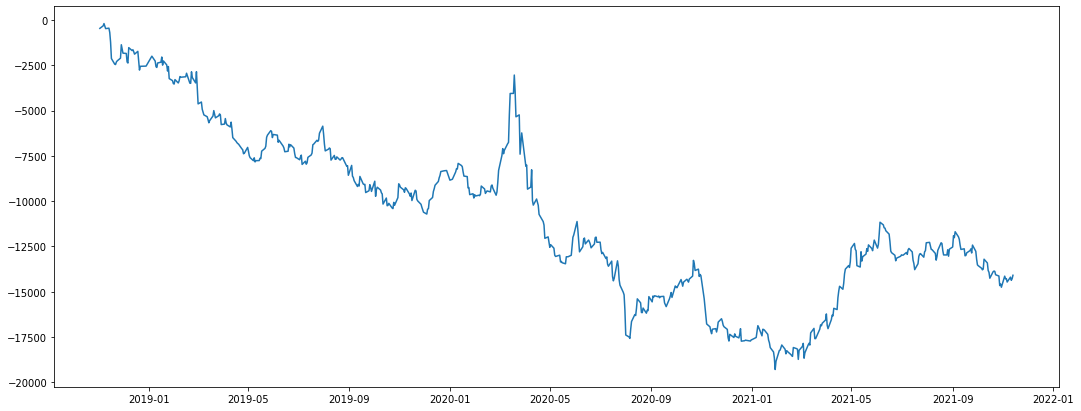

In [22]:
TOTAL_PNL = [0]
TRADE_DATES = list()
for correct_day in tqdm(np.unique(FX_data.index.date)[:]):
    Asian_end, Asian_start, Engilsh_end = selection_logic(correct_day)

    if (Asian_end in FX_data.index) and (Asian_start in FX_data.index) and (Engilsh_end in FX_data.index):
        sampling_data = FX_data.loc[Asian_start:Engilsh_end].open
        result = buying_trigger(sampling_data=sampling_data, median_dot=Asian_end, SLIPADGE=20, POSITION_MONEY_VOLUME=100_000)
        if result:
            TOTAL_PNL.append(TOTAL_PNL[-1] + result['operation_money_return'])
            #if TOTAL_PNL[-1] < 0:
            #    TOTAL_PNL[-1] = 0
            TRADE_DATES.append(result['position_close_time'])

TOTAL_PNL = TOTAL_PNL[1:]
plt.figure(figsize=(18,7))
plt.plot(TRADE_DATES, TOTAL_PNL)
plt.show()